In [12]:
# !pip install xarray fsspec
# !pip install h5netcdf netcdf4
# !pip install jinja2

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# Working with Xarray (Introduction)

## Importing Data Without Dask

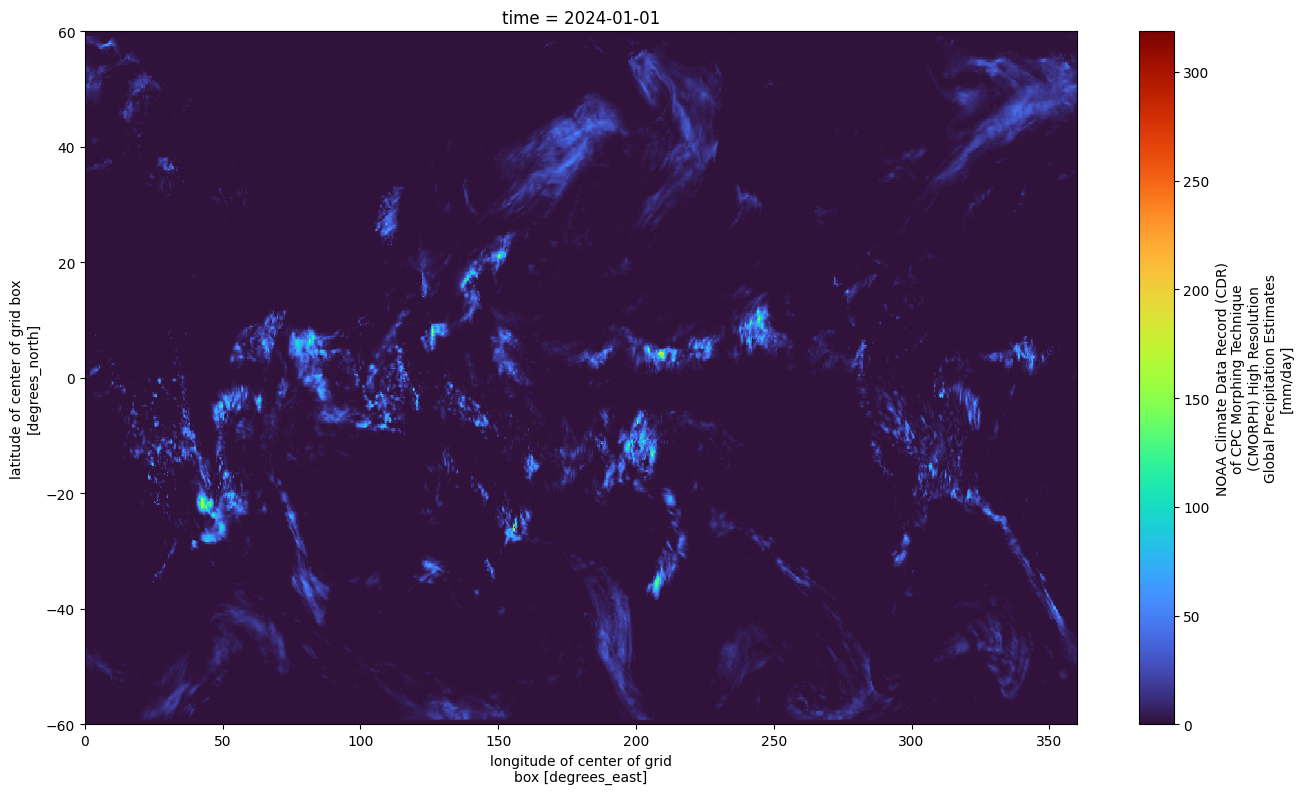

In [2]:
ds = xr.open_dataset(
    'CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20240101.nc'
)

# Plot using Xarray
fig, ax = plt.subplots(figsize=(16, 9))
ds['cmorph'].plot(
    ax = ax , 
    cmap = 'turbo'
)

In [3]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 1, nv: 2, lat: 480, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * lat          (lat) float32 2kB -59.88 -59.62 -59.38 ... 59.38 59.62 59.88
  * lon          (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] 16B ...
    lat_bounds   (lat, nv) float32 4kB ...
    lon_bounds   (lon, nv) float32 12kB ...
    cmorph       (time, lat, lon) float32 3MB ...
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.25
    geospatial_lon_units:       degrees_east

## Importing Climate Data with Dask

<xarray.DataArray 'cmorph' (time: 1, lat: 480, lon: 1440)> Size: 3MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-01
  * lat      (lat) float32 2kB -59.88 -59.62 -59.38 -59.12 ... 59.38 59.62 59.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

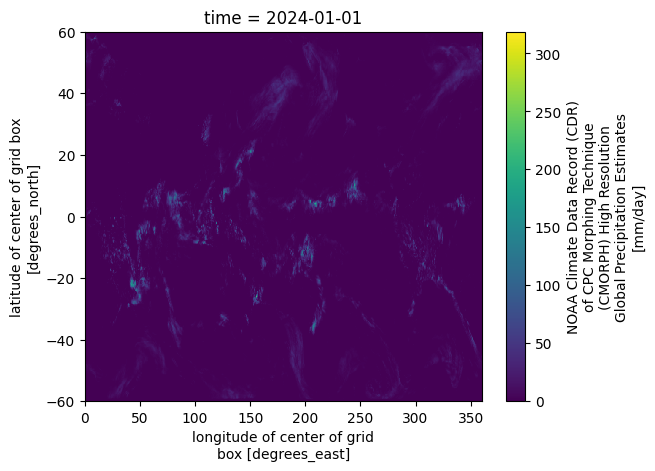

In [4]:
# Daily Dataset
ds = xr.open_dataset(
    'CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20240101.nc',
    chunks = {
        'time': 20 ,  # 20-days of data in Python at any time
        # 'lon' : 200 ,  # 200-pixels along the x-axis at any time
        # 'lat' : 100 ,  # 100-pixels along the y-axis at any time
    } ,
)

# Bring the chunks together, behind the scenes, and execute the lazily loaded dataset
ds['cmorph'][0].plot()  # Compute your dataset

ds_persist = ds['cmorph'].compute()  # Persisting lazily-laded dataset to Python's memory
ds_persist

## Summary Statistics

In [5]:
print(
    f'Min: {ds_persist.min()},\n \
    Mean: {ds_persist.mean()},\n \
    Max: {ds_persist.max()},\n \
    SD:{ds_persist.std()}'
     )

Min: <xarray.DataArray 'cmorph' ()> Size: 4B
array(0., dtype=float32),
     Mean: <xarray.DataArray 'cmorph' ()> Size: 4B
array(2.2866695, dtype=float32),
     Max: <xarray.DataArray 'cmorph' ()> Size: 4B
array(318.7, dtype=float32),
     SD:<xarray.DataArray 'cmorph' ()> Size: 4B
array(7.6298976, dtype=float32)


## Longitude from [0, 360] --> [-180, 180]

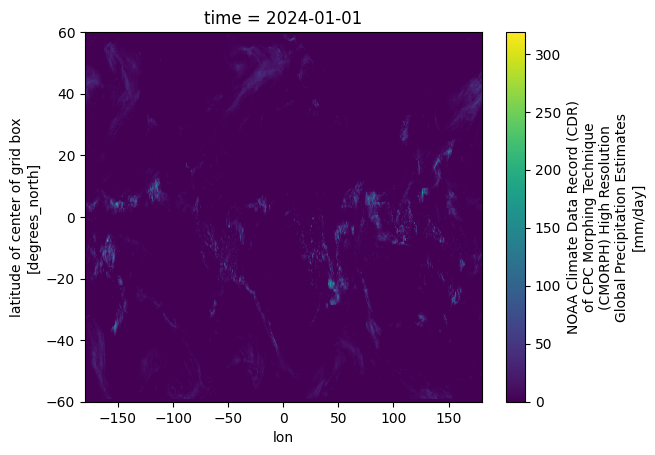

In [6]:
# Longitude coercion to [-180, 180]
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

ds['cmorph'].plot()

## Filtering the Dataset: Find the Maximum Pixel Value

In [7]:
%%time

# Find the maximum pixel value's coordinate location
ds_persist.where(
    ds_persist == ds_persist.max() ,
    drop = True
)

CPU times: user 8.58 ms, sys: 2.89 ms, total: 11.5 ms
Wall time: 10.7 ms


<xarray.DataArray 'cmorph' (time: 1, lat: 1, lon: 1)> Size: 4B
array([[[318.7]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-01
  * lat      (lat) float32 4B -25.88
  * lon      (lon) float32 4B 155.9
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

## Search Xarray Datasets using the Select

In [8]:
# Search inside of array to find specific pixel values
ds_persist.sel(
    lon = -117.1611,
    lat = 32.7157,
    method = 'nearest'
)


# Dask Array
ds.sel(
    lon = -117.1611,
    lat = 32.7157,
    method = 'nearest'
).compute()['cmorph']

<xarray.DataArray 'cmorph' (time: 1)> Size: 4B
array([0.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-01
    lat      float32 4B 32.62
    lon      float32 4B -117.1
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

## Perform Searches on Arrays to Create Task Graphs Using Dask

When using Dask, make sure your specific with what you want to output. This is necessary to show the series of operations in a task graph to sucessfully deliver your computed results (when executed).

FIRST, we filter by latitude (since that dimension is correct) and then we are dealing with only one latitude column from the array, after that we coerce longitude to the correct axis, and then search by our correct longitude coordinate to find San Diego. This will return a single pixel value for the given search location on our Dask Data Array.

In [9]:
%%time

# Latitude search (filtering by latitude to reduce the size of our data)
task_graph = ds.sel(
    lat = 32.7157,  # Latitude coordinate
    method = 'nearest'  # Search method
)['cmorph']

# Coerce my longitude dimension from [0, 360] to [-180, 180]
task_graph.coords['lon'] = (task_graph.coords['lon'] + 180) % 360 - 180
task_graph = task_graph.sortby(task_graph.lon)

# Search by my corrected longitude dimension
task_graph = task_graph.sel(
    lon = -117.1611,  # Longitude coordinate
    method = 'nearest'
)

# Execute the task graph that we created
print(task_graph.compute())

# Visualize the task graph (and expected output)
task_graph

<xarray.DataArray 'cmorph' (time: 1)> Size: 4B
array([0.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-01
    lat      float32 4B 32.62
    lon      float32 4B -117.1
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!
CPU times: user 12.6 ms, sys: 3.95 ms, total: 16.6 ms
Wall time: 15.3 ms


<xarray.DataArray 'cmorph' (time: 1)> Size: 4B
dask.array<getitem, shape=(1,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-01
    lat      float32 4B 32.62
    lon      float32 4B -117.1
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

## Importing Multiple Datasets (Files) with Xarray

### Loading all the datasets (files) into Python's memory

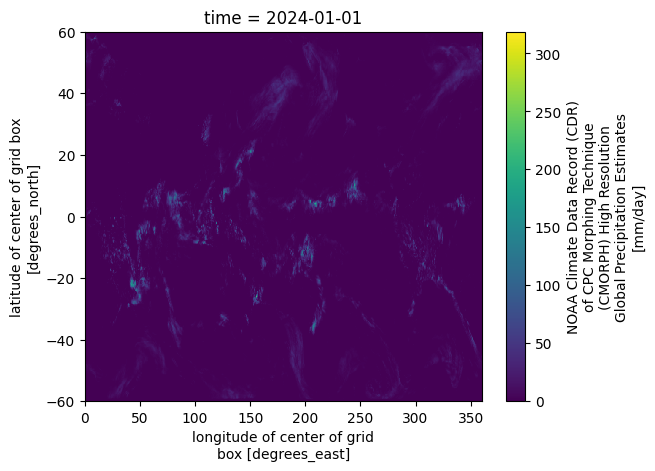

In [10]:
ds = xr.open_mfdataset(
    '*.nc',
    combine = 'by_coords' ,  # (Time, Longitude, Latitude) --> Spatiotemporal Data
)

ds['cmorph'][0].plot()

### Turn Dask ON --> Import in Chunks

In [11]:
ds = xr.open_mfdataset(
    '*.nc',
    chunks = {
        'time' : 1  # Working on 1-day of data at any time in Python
    } ,
    parallel = True ,  # Enables parallel processing across multiple arrays in Python
    combine = 'by_coords'
)

ds['cmorph']

: 

## Generate (and Compute) a Time Series for a Selected Point

We created a task graph that narrowed down the dataset to a single latitude column, selected the CMORPH variable, and then reprojected the longitude coordinate into the correct dimension, and after that, did a final search to find the matching longitude for downtown San Diego. We then computed the time series and plotted the result.

<xarray.DataArray 'cmorph' (time: 10)>
dask.array<getitem, shape=(10,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-01-10
    lat      float32 32.62
    lon      float32 -117.1
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

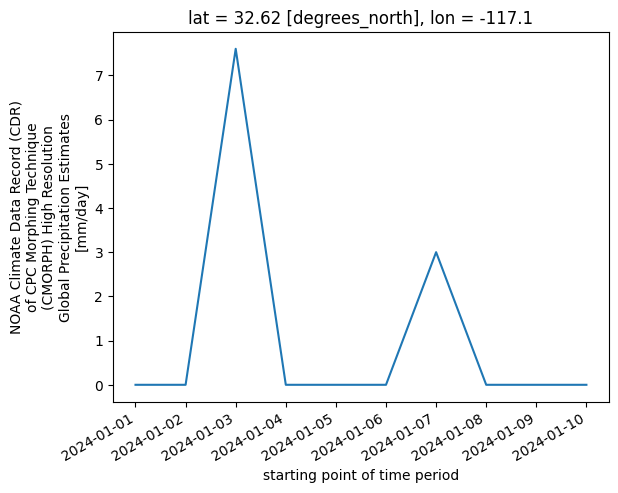

In [101]:
# Latitude search (filtering by latitude to reduce the size of our data)
task_graph = ds.sel(
    lat = 32.7157,  # Latitude coordinate
    method = 'nearest'  # Search method
)['cmorph']

# Coerce my longitude dimension from [0, 360] to [-180, 180]
task_graph.coords['lon'] = (task_graph.coords['lon'] + 180) % 360 - 180
task_graph = task_graph.sortby(task_graph.lon)

# Search by my corrected longitude dimension
task_graph = task_graph.sel(
    lon = -117.1611,  # Longitude coordinate
    method = 'nearest'
)

# Execute task graph
task_graph.compute().plot()

# Visualize how the data is partitioned into chunks --> see the expected output's shape
task_graph